# C8.3
Jeg Vet

huangzw29@mail2.sysu.edu.cn

2022-05-28

In [17]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp
import glob,os
from scipy.signal import argrelextrema

## Load data

In [18]:
def getallfile(path, extension):
    filepathdic = {}
    for root, dirs, files in os.walk(path):
        for file in files:
            if extension in file:
                filepath = root + "/" + file
                filepathdic[file]= filepath
    return filepathdic

In [19]:
dfdic = {}
path = "Input/Real-world/"
for fname, fpath in getallfile(path, ".csv").items():
    dfdic[fname.rstrip(".csv")] = pd.read_csv(fpath)
print(dfdic.keys())

dict_keys(['g', 'r'])


In [20]:
df1 = pd.concat([dfdic["g"]["uTc"]/0.039, dfdic["r"]["uTc"]/0.039], axis=1)
df1.columns = ["Glass", "Rubber"]
df1["t"] = np.arange(0, 15.5*60, 0.5*60)

df2 = pd.concat([dfdic["g"]["udT"]/0.039, dfdic["r"]["udT"]/0.039], axis=1)
df2.columns = ["Glass", "Rubber"]
df2["t"] = np.arange(0, 15.5*60, 0.5*60)

# df2
df1

,Glass,Rubber,t
0,-0.333333,-0.076923,0.0
1,-0.282051,0.128205,30.0
2,-0.282051,0.205128,60.0
3,-0.230769,0.333333,90.0
4,-0.153846,0.487179,120.0
5,-0.025641,0.692308,150.0
6,0.102564,0.897436,180.0
7,0.256410,1.128205,210.0
8,0.461538,1.333333,240.0
9,0.666667,1.589744,270.0


In [21]:
def smoothplot(df, par, dense=50, s=1, method="Rbf", scatter=False, 
               xlab="x", ylab="y", result_path="Output/smooth.png"):
    '''
    df: dataframe
    par: {"x": "", "y1": "", "y2": "", ...}
    s: smooth degree
    '''
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.interpolate import UnivariateSpline,Rbf
    import re
    from scipy.signal import argrelextrema
    # smooth
    x_dense = np.linspace(df[par["x"]].min(), df[par["x"]].max(), dense)
    ylist = list(filter(lambda y: re.match('y.*', y) != None, par.keys()))
    if method == "Rbf":
        for y in ylist:
            smoothfunc = Rbf(df[par["x"]], df[par[y]], smooth=s)
            globals()[y+"_smooth"] = smoothfunc(x_dense)
    elif method == "UnivariateSpline":
        for y in ylist:
            smoothfunc = UnivariateSpline(df[par["x"]], df[par[y]], s=s)
            globals()[y+"_smooth"] = smoothfunc(x_dense)
    
    # Plot
    plt.figure(figsize= (10, 6))
    ## lab
    if xlab == "x":
        xlab = par["x"]
    if ylab == "y":
        ylab = par["y"]
    ## Scatter
    if scatter == True:
        for i in np.arange(0, len(ylist), 1):
            x = np.array(df[par["x"]])
            y = np.array(df[par[ylist[i]]])
            plt.scatter(x, y, color=plt.cm.Set2(i), alpha=0.5, s=10)
            ## Add line:
            top_loc = np.argmax(y)
            # plt.vlines(x[top_loc], 0.1, y[top_loc], ls=':', color = plt.cm.Set2(i))
            plt.hlines(y[top_loc], 0, x[top_loc], ls=':', color = plt.cm.Set2(i))
            plt.annotate('{:.2f} K'.format(y[top_loc]), xy=(600, y[top_loc]+0.1), color=plt.cm.Set2(i)) 

    ## Smooth
    for i in np.arange(0, len(ylist), 1):
        x = x_dense
        y = eval(ylist[i]+"_smooth")
        plt.plot(x, y, color=plt.cm.Set2(i), label=par[ylist[i]])                          
    ## Lab
    plt.legend()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    # plt.title(y=-0.17)
    plt.savefig(result_path, bbox_inches = 'tight', dpi=300) 

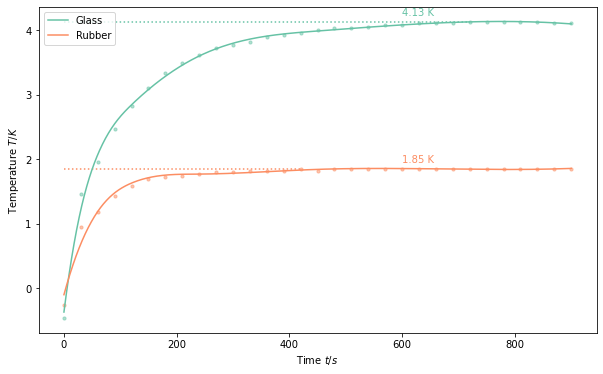

In [22]:
smoothplot(df2, {"x": "t", "y1": "Glass", "y2": "Rubber"}, 
    dense=1000, s=0.1, method="UnivariateSpline", scatter=True,
    xlab="Time $t/s$", ylab="Temperature $T /K$",
    result_path="Output/Real-world/fig.2.1.png")

In [23]:
def fitplot(df, par, dense=50, xlab="x", ylab="y", deg=1, result_path="Output/fit.png", label="Data", cut=0):
    '''
    df: dataframe
    par: {"x": "", "y1": "", "y2": "", ...}
    deg: fit degree
    '''
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    import re
    x_dense = np.linspace(df[par["x"]][cut:].min(), df[par["x"]][cut:].max(), dense)
    ylist = list(filter(lambda y: re.match('y.*', y) != None, par.keys()))
    for y in ylist:
        func = np.polyfit(df[par["x"]][cut:], df[par[y]][cut:], deg=deg) 
        globals()[y+"_reg"] = np.polyval(func, x_dense)
        globals()[y+"_r"] = np.corrcoef(df[par["x"]][cut:], df[par[y]][cut:])[0,1]
        globals()[y+"_coef_1"] = tuple(func)[0]
        globals()[y+"_coef_2"] = tuple(func)[1]
        

    plt.figure(figsize= (10, 6))
    
    for i in np.arange(0, len(ylist), 1):
        x = x_dense
        y = eval(ylist[i]+"_reg")
        plt.plot(x, y, color=plt.cm.Set2(i), label='Fit. \ny = {:.4f}x + {:.4f}\nr = {:.8f}'
                            .format(globals()[ylist[i]+"_coef_1"], globals()[ylist[i]+"_coef_2"], globals()[ylist[i]+"_r"]))    
        plt.scatter(df[par["x"]], df[par[ylist[i]]], color=plt.cm.Set2(i), label=par[ylist[i]], alpha=0.5, s=15)    
        sns.regplot(x=df[par["x"]][cut:], y=df[par[ylist[i]]][cut:], color = plt.cm.Set2(i), scatter = False)                          
    
    plt.legend()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    # plt.title(y=-0.17)
    plt.savefig(result_path, bbox_inches = 'tight', dpi=300)   

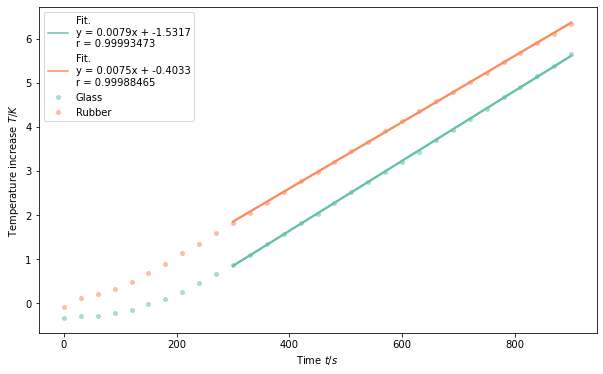

In [24]:
fitplot(df1, par={"x": "t", "y1": "Glass", "y2": "Rubber"}, deg=1, cut=10,
        xlab="Time $t/s$", ylab="Temperature increase $T /K$", 
        result_path="Output/Real-world/fig.2.2.png")